In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
if 'notebooks' in os.getcwd():
    os.chdir('..')

print(f'cwd: {os.getcwd()}')

cwd: /Users/gbemidebe/Documents/GitHub/RLseparation


Cases studied here:
- base: [1, -1] 
- case2: [1, -0.8]

In [3]:
# images folder
id = 'reward-two-case2'
numerical_id = 2
images_path = f'images/rl/{id}'
if not os.path.exists(images_path):
    os.makedirs(images_path)
else:
    os.system(f'rm {images_path}/*')
    
# model path
model_path = f'models/{id}'
if not os.path.exists(model_path):
    os.makedirs(model_path)
else:
    os.system(f'rm {model_path}/*')

rm: images/rl/reward-two-case2/*: No such file or directory
rm: models/reward-two-case2/*: No such file or directory


## Import libraries

In [4]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

from stable_baselines3 import A2C, PPO, SAC

from OptiDial import (RLperformanceMetrics, ENV, rolling_average, rescale_action, test_controller,
                     rescale_eposide_rewards, reward_two)

# Train controller

In [5]:
number_of_episodes = 30_000 # number of episodes
max_steps = 1 # number of steps per episode
window_size = 100 # window size for the rolling average
lb = [20, 0.1, 45, 0.1, 0.01] # lower bound for the action space
ub = [80, 2.0, 120, 2.0, 0.5] # upper bound for the action space
reward_function = reward_two # reward function
reward_weight = [1, -0.8] # reward weight

### Environment

In [6]:
# performance metrics
metrics = RLperformanceMetrics(params_files='OptiDial/params.yaml',
                               lb=lb, ub=ub)
# custom environment
env = ENV(rl_metrics=metrics, max_steps=1, reward_function=reward_two, reward_weight=[1, -1])
# check the env (If the environment don't follow the interface, an error will be thrown)
check_env(env, warn=True)

### A. PPO

In [7]:
# Choose your algorithm
ppo_env = Monitor(ENV(rl_metrics=metrics, max_steps=max_steps, reward_function=reward_function, reward_weight=reward_weight))
ppo_model = PPO("MlpPolicy", ppo_env, verbose=1, seed=2048, learning_rate=0.001)
# Train the agent
ppo_model.learn(total_timesteps=number_of_episodes)

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.512    |
| time/              |          |
|    fps             | 93       |
|    iterations      | 1        |
|    time_elapsed    | 22       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | 0.568       |
| time/                   |             |
|    fps                  | 89          |
|    iterations           | 2           |
|    time_elapsed         | 45          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.103630684 |
|    clip_fraction        | 0.581       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.01       |
|    explained_varia

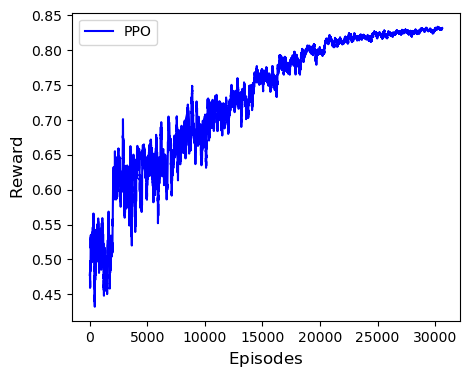

In [8]:
# Evaluate the agent
ppo_escaled_rewards = rescale_eposide_rewards(ppo_env.get_episode_rewards(), ppo_env.get_episode_lengths())
# moving average of results
ppo_average_results = rolling_average(ppo_escaled_rewards, window_size=window_size)
# plot the results
plt.figure(figsize=(5, 4))
plt.plot(ppo_average_results, label="PPO", color='blue')
plt.xlabel(r"$\rm Episodes$", fontsize=12)
plt.ylabel(r"$\rm Reward$", fontsize=12) 
plt.legend()
#plt.ylim(ymax=1)
# save the plot
plt.savefig(os.path.join(images_path, f'ppo_reward_{numerical_id}.png'))

In [9]:
# Evaluate the trained agent
mean_ppo_reward, std_pp_reward = evaluate_policy(ppo_model, ppo_env)
print(f"mean_reward: {mean_ppo_reward:.4f} +/- {std_pp_reward:.4f}")

mean_reward: 0.8368 +/- 0.0001


In [10]:
# save the model
ppo_model.save(os.path.join(model_path, f'ppo_reward_{numerical_id}'))

### B. SAC

In [11]:
# Choose your algorithm
SAC_env = Monitor(ENV(rl_metrics=metrics, max_steps=max_steps, reward_function=reward_function, reward_weight=reward_weight))
SAC_model = SAC("MlpPolicy", SAC_env, verbose=1, seed=2048, learning_rate=0.001)
# Train the agent
SAC_model.learn(total_timesteps=number_of_episodes)

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.483    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 82       |
|    time_elapsed    | 0        |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.558    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 76       |
|    time_elapsed    | 0        |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.552    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 62       |
|    time_elapsed    | 0      

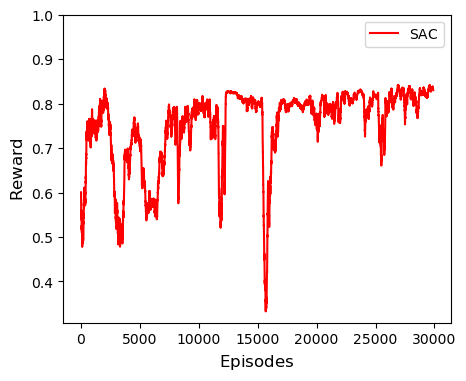

In [12]:
# Evaluate the agent
SAC_escaled_rewards = rescale_eposide_rewards(SAC_env.get_episode_rewards(), SAC_env.get_episode_lengths())
# moving average of results
SAC_average_results = rolling_average(SAC_escaled_rewards, window_size=window_size)
# plot the results
plt.figure(figsize=(5, 4))
plt.plot(SAC_average_results, label=r"$\rm SAC$", color='red')
plt.xlabel(r"$\rm Episodes$", fontsize=12)
plt.ylabel(r"$\rm Reward$", fontsize=12)
plt.legend()
plt.ylim(ymax=1)
# save the figure
plt.savefig(os.path.join(images_path, f'sac_reward_{numerical_id}.png'))


In [13]:
# Evaluate the trained agent
mean_SAC_reward, std_SAC_reward = evaluate_policy(SAC_model, SAC_env)
print(f"mean_reward: {mean_SAC_reward:.4f} +/- {std_SAC_reward:.4f}")

mean_reward: 0.8368 +/- 0.0196


In [14]:
# save the model
SAC_model.save(os.path.join(model_path, f'sac_reward_{numerical_id}'))

### C. A2C

In [15]:
# Choose your algorithm
A2C_env = Monitor(ENV(rl_metrics=metrics, max_steps=max_steps, reward_function=reward_function, reward_weight=reward_weight))
A2C_model = A2C("MlpPolicy", A2C_env, verbose=1, seed=2048, learning_rate=0.001)
# Train the agent
A2C_model.learn(total_timesteps=number_of_episodes)

Using cpu device
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 0.809    |
| time/                 |          |
|    fps                | 83       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -6.93    |
|    explained_variance | -0.021   |
|    learning_rate      | 0.001    |
|    n_updates          | 99       |
|    policy_loss        | 4.29     |
|    std                | 0.968    |
|    value_loss         | 0.422    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 0.826    |
| time/                 |          |
|    fps                | 84       |
|    iterations         | 200      |
|    time_elapsed      

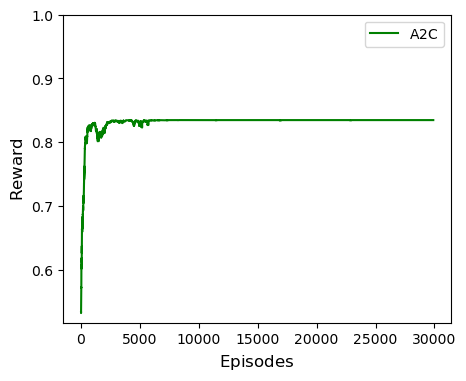

In [16]:
# Evaluate the agent
A2C_escaled_rewards = rescale_eposide_rewards(A2C_env.get_episode_rewards(), A2C_env.get_episode_lengths())
# moving average of results
A2C_average_results = rolling_average(A2C_escaled_rewards, window_size=window_size)
# plot the results
plt.figure(figsize=(5, 4))
plt.plot(A2C_average_results, label=r"$\rm A2C$", color='green')
plt.xlabel(r"$\rm Episodes$", fontsize=12)
plt.ylabel(r"$\rm Reward$", fontsize=12)
plt.ylim(ymax=1)
plt.legend()
# save the figure
plt.savefig(os.path.join(images_path, f'a2c_reward_{numerical_id}.png'))

In [17]:
# Evaluate the trained agent
mean_A2C_reward, std_A2C_reward = evaluate_policy(A2C_model, A2C_env)
print(f"mean_reward: {mean_A2C_reward:.4f} +/- {std_A2C_reward:.4f}")

mean_reward: 0.8346 +/- 0.0000


In [18]:
# save the model
A2C_model.save(os.path.join(model_path, f'a2c_reward_{numerical_id}'))

## Compare

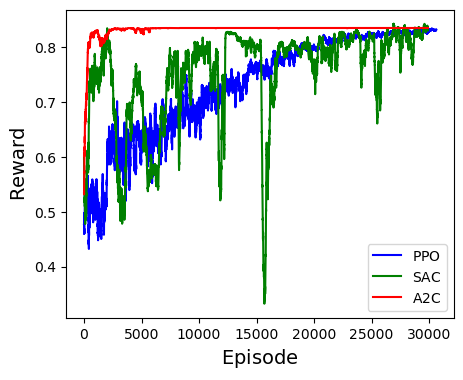

In [19]:
# plot the results
plt.figure(figsize=(5, 4))
plt.plot(ppo_average_results, label=r'$\rm PPO$', color='blue')
plt.plot(SAC_average_results, label=r'$\rm SAC$', color='green')
plt.plot(A2C_average_results, label=r'$\rm A2C$', color='red')
plt.xlabel(r'$\rm Episode$', fontsize=14)
plt.ylabel(r'$\rm Reward$', fontsize=14)
plt.legend()
plt.savefig(os.path.join(images_path, f'combined_reward_{numerical_id}.png'))

# Test controller

## A. PPO

In [20]:
ppo_action_recorder = test_controller(ppo_env, ppo_model, n_steps=10, id='ppo', reward_id=2, ub=ub, lb=lb, write_path=model_path)

Step = 1
Action = [80.         2.        99.42465    1.1854907  0.4109236]
obs = [  0.934523    1.2215441   2.2404447 103.30713  ]
reward = 0.8367994704839743
terminated =False
Step = 2
Action = [80.         2.        99.658394   1.1810718  0.4110846]
obs = [  0.93494445   1.226472     2.2260232  103.23915   ]
reward = 0.8368267135603351
terminated =False
Step = 3
Action = [ 80.           2.         103.16028      1.1994487    0.40975377]
obs = [  0.93610317   1.2422575    2.186376   104.81076   ]
reward = 0.8367225619424459
terminated =False
Step = 4
Action = [ 80.          2.        100.1238      1.1941708   0.410294 ]
obs = [  0.93448514   1.2214049    2.24174    103.80402   ]
reward = 0.8367727592956292
terminated =False
Step = 5
Action = [ 80.           2.         102.1611       1.2091073    0.41823083]
obs = [  0.93503577   1.2275432    2.2229002  103.628944  ]
reward = 0.836832284321712
terminated =False
Step = 6
Action = [ 80.          2.        103.28178     1.1975594   0.4091

## B. SAC

In [21]:
SAC_action_recorder = test_controller(SAC_env, SAC_model, n_steps=10, id='sac', reward_id=2, ub=ub, lb=lb, write_path=model_path)

Step = 1
Action = [76.          1.3826659  47.602943    0.24877465  0.46377334]
obs = [ 0.96362954  1.20944     1.244498   54.089424  ]
reward = 0.8668743506087158
terminated =False
Step = 2
Action = [54.          1.831228   59.582863    0.36350635  0.3315123 ]
obs = [ 0.95009077  1.4752123   1.7077585  69.27439   ]
reward = 0.8320737675998319
terminated =False
Step = 3
Action = [75.          1.7704     52.29274     0.3551432   0.39856696]
obs = [ 0.9602553  1.4337747  1.3599555 64.22499  ]
reward = 0.8455533251414223
terminated =False
Step = 4
Action = [39.          1.7358142  58.78739     0.3001815   0.36564302]
obs = [ 0.93231833  1.3871915   2.3158822  61.366447  ]
reward = 0.8213430149874084
terminated =False
Step = 5
Action = [42.          1.7648925  58.478344    0.3136775   0.36196473]
obs = [ 0.93692136  1.4116951   2.1583798  62.740524  ]
reward = 0.8239857383074044
terminated =False
Step = 6
Action = [34.         1.6115957 59.028347   0.2766527  0.3641582]
obs = [ 0.9127553  

## C. A2C

In [22]:
A2C_action_recorder = test_controller(A2C_env, A2C_model, n_steps=10, id='a2c', reward_id=2, ub=ub, lb=lb, write_path=model_path)

Step = 1
Action = [ 80.    2.  120.    2.    0.5]
obs = [  0.9117627   0.96502     3.01924   112.32524  ]
reward = 0.8345611116805862
terminated =False
Step = 2
Action = [ 80.    2.  120.    2.    0.5]
obs = [  0.9117627   0.96502     3.01924   112.32524  ]
reward = 0.8345611116805862
terminated =False
Step = 3
Action = [ 80.    2.  120.    2.    0.5]
obs = [  0.9117627   0.96502     3.01924   112.32524  ]
reward = 0.8345611116805862
terminated =False
Step = 4
Action = [ 80.    2.  120.    2.    0.5]
obs = [  0.9117627   0.96502     3.01924   112.32524  ]
reward = 0.8345611116805862
terminated =False
Step = 5
Action = [ 80.    2.  120.    2.    0.5]
obs = [  0.9117627   0.96502     3.01924   112.32524  ]
reward = 0.8345611116805862
terminated =False
Step = 6
Action = [ 80.    2.  120.    2.    0.5]
obs = [  0.9117627   0.96502     3.01924   112.32524  ]
reward = 0.8345611116805862
terminated =False
Step = 7
Action = [ 80.    2.  120.    2.    0.5]
obs = [  0.9117627   0.96502     3.019